In [146]:
import gzip
import json
import pickle 

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

#### Data Wrangling

In [147]:
def wrangle(filename):
    # Open compressed file, load into dictionary
    with gzip .open(filename) as f:
        data = json.load(f)
    # Load dictionaary into a Dataframe
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df

In [148]:
df = wrangle("./data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


#### Creating the model

In [149]:
target_column = "bankrupt"
X =df.drop(columns=target_column)

y = df[target_column]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [150]:

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


In [151]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)


(15216, 64)


In [152]:
acc_baseline= y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:",  round(acc_baseline,4))

Baseline Accuracy: 0.9533


In [153]:
clf = make_pipeline(SimpleImputer(), RandomForestClassifier(random_state=42))
clf

,steps,"[('simpleimputer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,n_estimators,100


    K-Folds cross Validation

In [154]:
cv_acc_scores = cross_val_score(clf,X_train_over,y_train_over,cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99605782 0.99769964 0.99802826 0.99638515 0.99868551]


##### Hyperparameter tuning

    n_estimators - Number of trees in a forest, default 100
    max_depth - Number of splits, default none
    strategy - imputing strategy - mean/median etc

In [155]:
params = {
    "simpleimputer__strategy":["mean","median"],
    "randomforestclassifier__n_estimators":range(25,100,25),
    "randomforestclassifier__max_depth":range(10,50,10),
}

    Grid Search

In [156]:
model =GridSearchCV(
    clf, 
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'randomforestclassifier__max_depth': range(10, 50, 10), 'randomforestclassifier__n_estimators': range(25, 100, 25), 'simpleimputer__strategy': ['mean', 'median']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [157]:
# Train model
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'randomforestclassifier__max_depth': range(10, 50, 10), 'randomforestclassifier__n_estimators': range(25, 100, 25), 'simpleimputer__strategy': ['mean', 'median']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


    Grid Search CV results

In [158]:
type(model.cv_results_)

dict

In [159]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.533528,0.036352,0.017296,0.001741,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.972733,0.977982,0.974696,0.979625,0.982254,0.977458,0.003404,21
1,1.649474,0.062575,0.016220,0.002620,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.967477,0.974367,0.979625,0.972724,0.970753,0.972989,0.004035,24
2,3.042622,0.048274,0.028084,0.002942,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.972733,0.981597,0.976668,0.976339,0.983897,0.978247,0.003992,20
3,3.039100,0.062281,0.024025,0.001109,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.968463,0.976339,0.976339,0.976996,0.974367,0.974501,0.003145,23
4,4.338328,0.032814,0.032675,0.004743,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.974047,0.978968,0.976996,0.978311,0.983240,0.978313,0.002988,19


    Training Time vs N estimators

In [160]:
# mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# cv_results[mask]

Text(0.5, 1.0, 'Training Time vs Estimators (max_depth =10)')

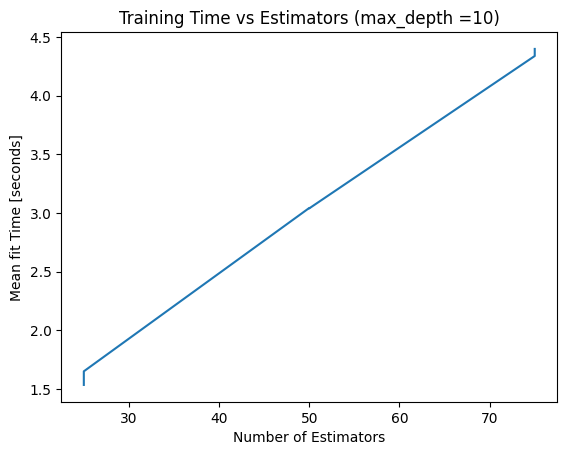

In [161]:
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
#Plot fit time vs n_estimators

plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)

plt.xlabel("Number of Estimators")
plt.ylabel("Mean fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth =10)")

    Training time vs max-depth

Text(0.5, 1.0, 'Training Time vs Max-depth (number of estimators=25)')

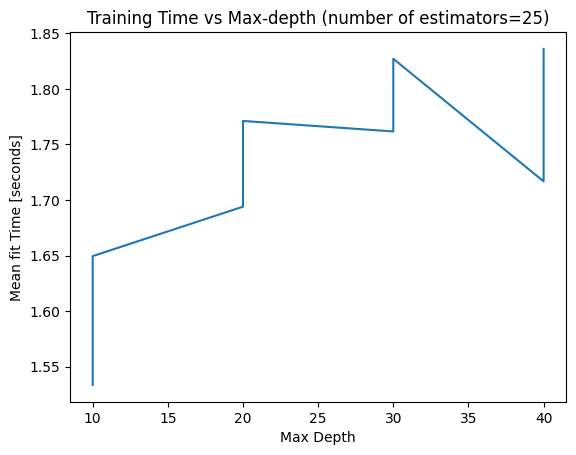

In [162]:
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
#Plot fit time vs n_estimators

plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)

plt.xlabel("Max Depth")
plt.ylabel("Mean fit Time [seconds]")
plt.title("Training Time vs Max-depth (number of estimators=25)")

In [163]:
cv_results[mask][["mean_fit_time","param_randomforestclassifier__max_depth","param_simpleimputer__strategy"]]

,mean_fit_time,param_randomforestclassifier__max_depth,param_simpleimputer__strategy
0,1.533528,10,mean
1,1.649474,10,median
6,1.693996,20,mean
7,1.771162,20,median
12,1.761710,30,mean
13,1.827125,30,median
18,1.716763,40,mean
19,1.835992,40,median


    Extracting the best hyperparameters

In [164]:
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

In [165]:
model.best_score_

np.float64(0.9976341298160445)

In [166]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9999
Test Accuracy: 0.9529


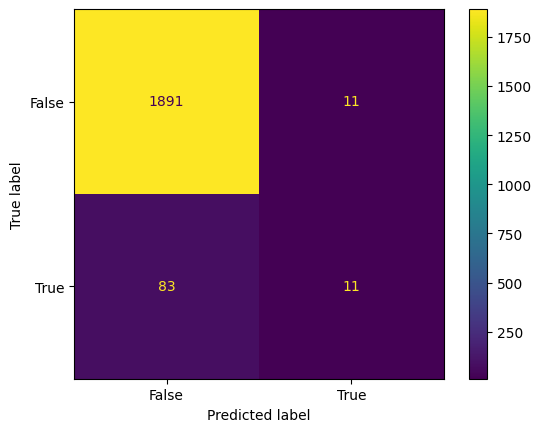

In [167]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

#### Communicating results

In [168]:
features = X_train_over.columns

In [169]:
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
importances

array([0.01392154, 0.01239032, 0.00997665, 0.00949775, 0.02099859,
       0.01887586, 0.01016092, 0.01331089, 0.01291616, 0.0122436 ,
       0.01006834, 0.01749439, 0.03557234, 0.00937208, 0.01458321,
       0.03136269, 0.01095727, 0.01318649, 0.01276984, 0.00971825,
       0.0222956 , 0.01316677, 0.01062546, 0.05534748, 0.01967022,
       0.03219582, 0.06152341, 0.01228488, 0.01745744, 0.01017813,
       0.01093199, 0.00729047, 0.00694466, 0.0276444 , 0.02047921,
       0.00971443, 0.01020878, 0.01955395, 0.01645449, 0.01455924,
       0.01429475, 0.01469877, 0.00826924, 0.01190844, 0.01215907,
       0.03598959, 0.01092169, 0.01117635, 0.01211587, 0.01030177,
       0.0122249 , 0.00749708, 0.01074817, 0.01116   , 0.01314532,
       0.01386342, 0.01088427, 0.01947454, 0.00676125, 0.01228169,
       0.01204549, 0.0078964 , 0.00930282, 0.0129751 ])

In [170]:
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp

feat_59    0.006761
feat_33    0.006945
feat_32    0.007290
feat_52    0.007497
feat_62    0.007896
             ...   
feat_26    0.032196
feat_13    0.035572
feat_46    0.035990
feat_24    0.055347
feat_27    0.061523
Length: 64, dtype: float64

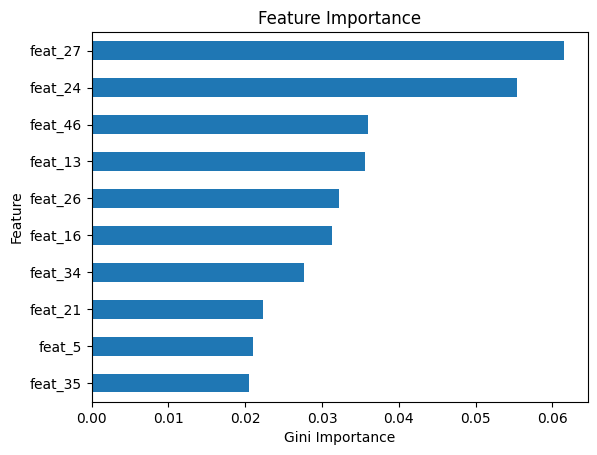

In [171]:
# Get feature names from training data
features = X_train_over.columns
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()


# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [172]:
# Save your model as 'model-5-2.pkl'

with open("model-5-3.pkl","wb") as f:
    pickle.dump(model,f)

In [173]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath,"rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

In [174]:
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34    False
36    False
40    False
Name: bankrupt, dtype: bool